# Multi-Step MLP Models

references :

- How to Develop Multilayer Perceptron Models for Time Series Forecasting

  https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/
  


- Exploratory Configuration of a Multilayer Perceptron Network for Time Series Forecasting 

  https://machinelearningmastery.com/exploratory-configuration-multilayer-perceptron-network-time-series-forecasting/  


## Example case

In [ ]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib

##### transform the data

In [21]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps_in, n_steps_out = 3, 2

# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)

# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]


##### build model 

In [22]:
# define model
model = Sequential()

# hidden layer, 100 neurons, relu activation function
model.add(Dense(100, activation='relu', input_dim=n_steps)) 

# output layer
model.add(Dense(n_steps_out))

# loss function
model.compile(optimizer='adam', loss='mse')

##### fit model

In [23]:
# fit model
model.fit(X, y, epochs=2000, verbose=0)

In [24]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[101.38835 113.17945]]


##### calculate MSE

In [27]:
# calculate the MSE

y_test = array([100, 110])
mse = mean_squared_error([y_test], yhat)
mse

6.018214156065369

## Web traffic case

In [18]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

##### read dataset

In [19]:
wt_df = read_csv('train_2.csv', nrows=1)
wt_df

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,...,19,33,33,18,16,27,29,23,54,38


##### select and transform dataframe row to sequence

In [20]:
# take only the values without the page name

def get_seq_by_row(input_df, row_num):
    new_seq = np.delete(input_df.iloc[row_num].values, 0)
    return new_seq

wt_seq = get_seq_by_row(wt_df,0)

In [21]:
wt_seq

array([18, 11, 5, 13, 14, 9, 9, 22, 26, 24, 19, 10, 14, 15, 8, 16, 8, 8,
       16, 7, 11, 10, 20, 18, 15, 14, 49, 10, 16, 18, 8, 5, 9, 7, 13, 9,
       7, 4, 11, 10, 5, 9, 9, 9, 9, 13, 4, 15, 25, 9, 5, 6, 20, 3, 14, 46,
       5, 5, 13, 4, 9, 10, 9, 11, 11, 11, 9, 15, 5, 10, 7, 4, 8, 9, 10, 6,
       13, 16, 6, 24, 9, 11, 12, 8, 14, 6, 6, 11, 14, 6, 10, 20, 7, 15, 8,
       15, 5, 8, 8, 5, 11, 165, 34, 6, 13, 8, 9, 11, 26, 18, 3, 5, 12, 6,
       16, 19, 9, 10, 11, 11, 7, 9, 10, 24, 6, 6, 8, 16, 13, 10, 10, 6, 5,
       20, 6, 47, 9, 9, 12, 11, 17, 15, 14, 11, 97, 11, 12, 11, 14, 15,
       12, 104, 5, 22, 45, 75, 29, 34, 20, 12, 25, 9, 62, 20, 19, 8, 23,
       13, 16, 34, 36, 11, 18, 12, 24, 30, 27, 44, 35, 53, 11, 26, 13, 18,
       9, 16, 6, 19, 20, 19, 22, 30, 14, 16, 22, 15, 15, 26, 16, 13, 27,
       18, 13, 32, 31, 16, 38, 18, 9, 14, 10, 24, 8, 15, 18, 10, 23, 17,
       11, 26, 14, 8, 12, 9, 11, 34, 17, 29, 11, 9, 14, 21, 12, 11, 13,
       11, 13, 16, 13, 19, 21, 14, 11, 35,

##### transform sequence to supervised format

In [22]:
# frame a sequence as a supervised learning problem

def timeseries_to_supervised(data, lag=1, stepahead=1):
    df = DataFrame(data)
    col_num = lag+stepahead
    columns = [df.shift(i) for i in range(1, col_num)]
    columns = list(reversed(columns))
    columns.append(df)
    df = concat(columns, axis=1)    
    return df.values[col_num - 1:,:]

In [23]:
time_step_lag = 2
time_step_ahead = 3

In [24]:
wt_supervised = timeseries_to_supervised(wt_seq, time_step_lag, time_step_ahead)
wt_supervised

array([[18, 11, 5, 13, 14],
       [11, 5, 13, 14, 9],
       [5, 13, 14, 9, 9],
       ...,
       [18, 16, 27, 29, 23],
       [16, 27, 29, 23, 54],
       [27, 29, 23, 54, 38]], dtype=object)

#### split train and test set

In [25]:
def split_train_and_test_set(dataset, num_of_test_set=12):
    num_of_test_set = -1 * num_of_test_set
    return dataset[0:num_of_test_set], dataset[num_of_test_set:]    

In [26]:
train, test = split_train_and_test_set(wt_supervised)

In [27]:
test

array([[25, 47, 44, 26, 24],
       [47, 44, 26, 24, 21],
       [44, 26, 24, 21, 19],
       [26, 24, 21, 19, 33],
       [24, 21, 19, 33, 33],
       [21, 19, 33, 33, 18],
       [19, 33, 33, 18, 16],
       [33, 33, 18, 16, 27],
       [33, 18, 16, 27, 29],
       [18, 16, 27, 29, 23],
       [16, 27, 29, 23, 54],
       [27, 29, 23, 54, 38]], dtype=object)

#### scale sequence value

In [28]:
# scale train and test data to [-1, 1]

def scale(train, test):
    
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)

    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    
    return scaler, train_scaled, test_scaled

In [29]:
scaler, train_scaled, test_scaled = scale(train, test)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
test_scaled

array([[-0.90965092, -0.81930185, -0.83162218, -0.90554415, -0.9137577 ],
       [-0.81930185, -0.83162218, -0.90554415, -0.9137577 , -0.92607803],
       [-0.83162218, -0.90554415, -0.9137577 , -0.92607803, -0.93429158],
       [-0.90554415, -0.9137577 , -0.92607803, -0.93429158, -0.87679671],
       [-0.9137577 , -0.92607803, -0.93429158, -0.87679671, -0.87679671],
       [-0.92607803, -0.93429158, -0.87679671, -0.87679671, -0.93839836],
       [-0.93429158, -0.87679671, -0.87679671, -0.93839836, -0.94661191],
       [-0.87679671, -0.87679671, -0.93839836, -0.94661191, -0.90143737],
       [-0.87679671, -0.93839836, -0.94661191, -0.90143737, -0.89322382],
       [-0.93839836, -0.94661191, -0.90143737, -0.89322382, -0.91786448],
       [-0.94661191, -0.90143737, -0.89322382, -0.91786448, -0.79055441],
       [-0.90143737, -0.89322382, -0.91786448, -0.79055441, -0.85626283]])

In [31]:
test_scaled[:,0:-1]

array([[-0.90965092, -0.81930185, -0.83162218, -0.90554415],
       [-0.81930185, -0.83162218, -0.90554415, -0.9137577 ],
       [-0.83162218, -0.90554415, -0.9137577 , -0.92607803],
       [-0.90554415, -0.9137577 , -0.92607803, -0.93429158],
       [-0.9137577 , -0.92607803, -0.93429158, -0.87679671],
       [-0.92607803, -0.93429158, -0.87679671, -0.87679671],
       [-0.93429158, -0.87679671, -0.87679671, -0.93839836],
       [-0.87679671, -0.87679671, -0.93839836, -0.94661191],
       [-0.87679671, -0.93839836, -0.94661191, -0.90143737],
       [-0.93839836, -0.94661191, -0.90143737, -0.89322382],
       [-0.94661191, -0.90143737, -0.89322382, -0.91786448],
       [-0.90143737, -0.89322382, -0.91786448, -0.79055441]])

#### build model

In [32]:
# fit an MLP network to training data

def fit_model(train, batch_size, nb_epoch, neurons, time_step_ahead):
    
    X, y = train[:, 0:-time_step_ahead], train[:, -time_step_ahead:]

    model = Sequential()
    
    # hidden layer
    model.add(Dense(neurons, activation='relu', input_dim=X.shape[1]))
    
    # output layer
    model.add(Dense(time_step_ahead))
    
    # loss function
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # model fitting
    #model.fit(X, y, epochs=nb_epoch, batch_size=batch_size, verbose=0, shuffle=False)
    model.fit(X, y, epochs=nb_epoch, verbose=0, shuffle=False)
    
    return model

#### fit model 

In [33]:
batch_size = 4
epochs = 1000
neurons = 3

In [34]:
model = fit_model(train_scaled, batch_size, epochs, neurons, time_step_ahead)

#### make forecasting

In [35]:
def evaluate(model, scaled_input, time_step_ahead):
    
    eval_input = scaled_input[:,0:-time_step_ahead]
    
    output = model.predict(eval_input)
    
    return output

In [36]:
train_output = evaluate(model, train_scaled, time_step_ahead)
train_output

array([[-0.92113376, -0.9209783 , -0.91949534],
       [-0.929138  , -0.9267119 , -0.9242062 ],
       [-0.92542183, -0.92450964, -0.9224013 ],
       ...,
       [-0.89172065, -0.8991989 , -0.9015944 ],
       [-0.90830106, -0.91199553, -0.91211724],
       [-0.90759885, -0.91162246, -0.91181195]], dtype=float32)

In [37]:
test_output = evaluate(model, test_scaled, time_step_ahead)
test_output

array([[-0.8889869 , -0.89899945, -0.9014479 ],
       [-0.8814206 , -0.89281493, -0.8963591 ],
       [-0.89726716, -0.9036268 , -0.90523684],
       [-0.9070426 , -0.9110991 , -0.9113807 ],
       [-0.9103643 , -0.9134335 , -0.91329825],
       [-0.9133347 , -0.91558135, -0.91506314],
       [-0.9029755 , -0.90871024, -0.90942323],
       [-0.8966242 , -0.90374076, -0.90533614],
       [-0.9086955 , -0.91186345, -0.9120046 ],
       [-0.91710997, -0.9182707 , -0.91727257],
       [-0.909165  , -0.9130241 , -0.9129664 ],
       [-0.90256524, -0.9080366 , -0.908866  ]], dtype=float32)

#### invert scale the prediction

In [38]:
# inverse scaling for a forecasted value

def invert_scale(scaler, X, yhat):    
    new_row = [x for x in X] + [x for x in yhat]    
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    
    return inverted[0, -len(yhat):]

def invert_scale_prediction(scaler, scaled_set, scaled_output):
    scaled_input = scaled_set[:,0:-time_step_ahead]
    predictions = list()

    for i in range(len(scaled_output)):
        yhat = scaled_output[i]
        X = scaled_input[i]

        # invert scaling
        yhat = invert_scale(scaler, X, yhat)    

        # store forecast
        predictions.append(yhat)
    
    return predictions

In [39]:
train_unscaled_output = invert_scale_prediction(scaler, train_scaled, train_output)
train_unscaled_output

[array([22.20393026, 22.24178207, 22.6028837 ]),
 array([20.25489584, 20.84564823, 21.45579097]),
 array([21.15978342, 21.38190156, 21.89528126]),
 array([22.23947439, 22.20520747, 22.57220167]),
 array([21.37014544, 21.6323505 , 22.10204387]),
 array([20.81781089, 21.20018965, 21.74661711]),
 array([23.36526096, 22.91431934, 23.15385395]),
 array([25.58516514, 24.56535783, 24.51094586]),
 array([25.63512141, 24.64737493, 24.57879755]),
 array([24.43440044, 23.81521565, 23.8953895 ]),
 array([22.11844438, 22.1963686 , 22.56569952]),
 array([21.90808237, 21.94590515, 22.35895142]),
 array([22.54590279, 22.42349398, 22.75153333]),
 array([21.28464505, 21.58692253, 22.0648742 ]),
 array([22.07905412, 22.03676111, 22.43327624]),
 array([21.39512357, 21.67336631, 22.13594794]),
 array([20.511397  , 20.98190314, 21.56727093]),
 array([22.07905412, 22.03676111, 22.43327624]),
 array([21.19914466, 21.54150906, 22.02770454]),
 array([20.98878264, 21.29103109, 21.82094193]),
 array([21.2347033 ,

In [40]:
test_unscaled_output = invert_scale_prediction(scaler, test_scaled, test_output)
test_unscaled_output

[array([30.03169337, 27.59363329, 26.99743825]),
 array([31.8740809 , 29.09956351, 28.23656255]),
 array([28.01544586, 26.4668743 , 26.0748294 ]),
 array([25.63512141, 24.64737493, 24.57879755]),
 array([24.8263002 , 24.07894465, 24.11187631]),
 array([24.10299391, 23.55594236, 23.68212473]),
 array([26.62546584, 25.22905624, 25.05544299]),
 array([28.17200547, 26.43912405, 26.05064952]),
 array([25.23264113, 24.46125084, 24.42688233]),
 array([23.18372321, 22.90108281, 23.14412975]),
 array([25.11831647, 24.17862496, 24.19268876]),
 array([26.72536385, 25.39309043, 25.19113186])]

#### calculate root mean squared error

In [41]:
def calculate_rmse(original, prediction, time_step_ahead):
    
    test_output = original[:,-time_step_ahead:]
    rmse = sqrt(mean_squared_error(test_output, prediction))
    
    return rmse

In [42]:
train_rmse = calculate_rmse(train, train_unscaled_output, time_step_ahead)

print('Train RMSE: %.3f' % (train_rmse))

Train RMSE: 25.903


In [43]:
test_rmse = calculate_rmse(test, test_unscaled_output, time_step_ahead)

print('Test RMSE: %.3f' % (test_rmse))

Test RMSE: 9.700


#### vary the time step lag

In [44]:
# config

# time_step_lag = 2
time_step_lag_array = np.arange(1,11)

time_step_ahead = 7

num_of_test_set = 12

batch_size = 4
epochs = 1000
neurons = 3



train_rmse_array = []
test_rmse_array = []

for time_step_lag in time_step_lag_array:

    # tranform data to NN input format
    wt_supervised = timeseries_to_supervised(wt_seq, time_step_lag, time_step_ahead)

    # split train and test set
    train, test = split_train_and_test_set(wt_supervised)

    # scale dataset
    scaler, train_scaled, test_scaled = scale(train, test)
    
    # fit model
    model = fit_model(train_scaled, batch_size, epochs, neurons, time_step_ahead)

    # evaluate train set
    train_output = evaluate(model, train_scaled, time_step_ahead)
    train_unscaled_output = invert_scale_prediction(scaler, train_scaled, train_output)
    train_rmse = calculate_rmse(train, train_unscaled_output, time_step_ahead)
    train_rmse_array.append(train_rmse)
    
    # evaluate test set
    test_output = evaluate(model, test_scaled, time_step_ahead)
    test_unscaled_output = invert_scale_prediction(scaler, test_scaled, test_output)
    test_rmse = calculate_rmse(test, test_unscaled_output, time_step_ahead)
    test_rmse_array.append(test_rmse)
    
    print('%d) TrainRMSE=%f, TestRMSE=%f' % (time_step_lag, train_rmse, test_rmse))    

C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


1) TrainRMSE=26.169259, TestRMSE=9.649354


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


2) TrainRMSE=26.153213, TestRMSE=9.558824


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


3) TrainRMSE=26.080905, TestRMSE=9.627785


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


4) TrainRMSE=26.131499, TestRMSE=9.695965


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


5) TrainRMSE=26.154565, TestRMSE=9.545651


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


6) TrainRMSE=26.217309, TestRMSE=10.100146


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


7) TrainRMSE=26.173089, TestRMSE=9.474815


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


8) TrainRMSE=26.204744, TestRMSE=9.495445


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


9) TrainRMSE=26.362409, TestRMSE=10.071559


C:\Program Files\Anaconda3\lib\site-packages\sklearn\utils\validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


10) TrainRMSE=26.239765, TestRMSE=10.065865


#### plot RMSE

<IPython.core.display.Javascript object>


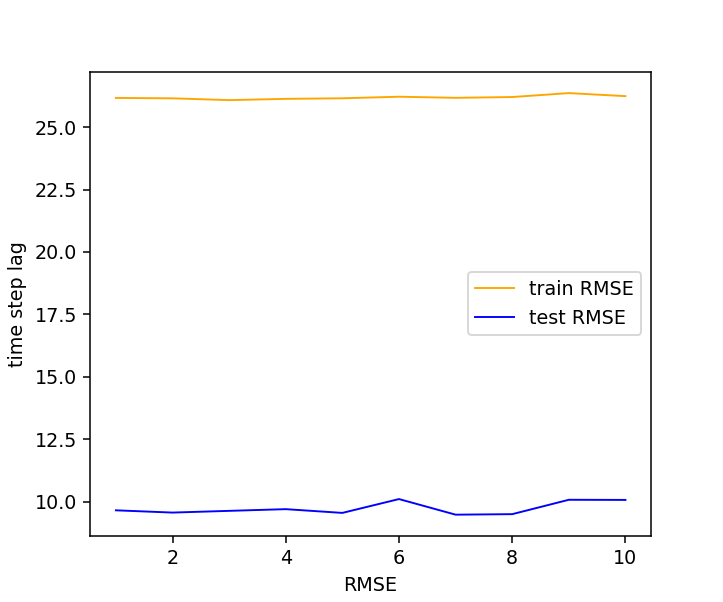

In [46]:
%matplotlib notebook

plt.xlabel('RMSE')
plt.ylabel('time step lag')
plt.plot(time_step_lag_array, train_rmse_array, '-', linewidth=1, color='orange', label='train RMSE')
plt.plot(time_step_lag_array, test_rmse_array, '-', linewidth=1, color='blue', label='test RMSE')  
plt.legend(loc='right')
plt.show()